In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
actnum = np.repeat(np.expand_dims(np.loadtxt('data/NPD5_ActiveCells.txt', skiprows=1).flatten().reshape(100,100,11, order='F'),0), 10, 0)
print(actnum.shape)

perm_all = pd.read_csv('sample_johansen_perm.csv')
perm_arr = np.moveaxis(np.array(perm_all).reshape(100,100,11,10, order='F'), -1,0)
print(perm_arr.shape)

perm_masked = np.ma.masked_where(actnum==0, perm_arr)

(10, 100, 100, 11)
(10, 100, 100, 11)


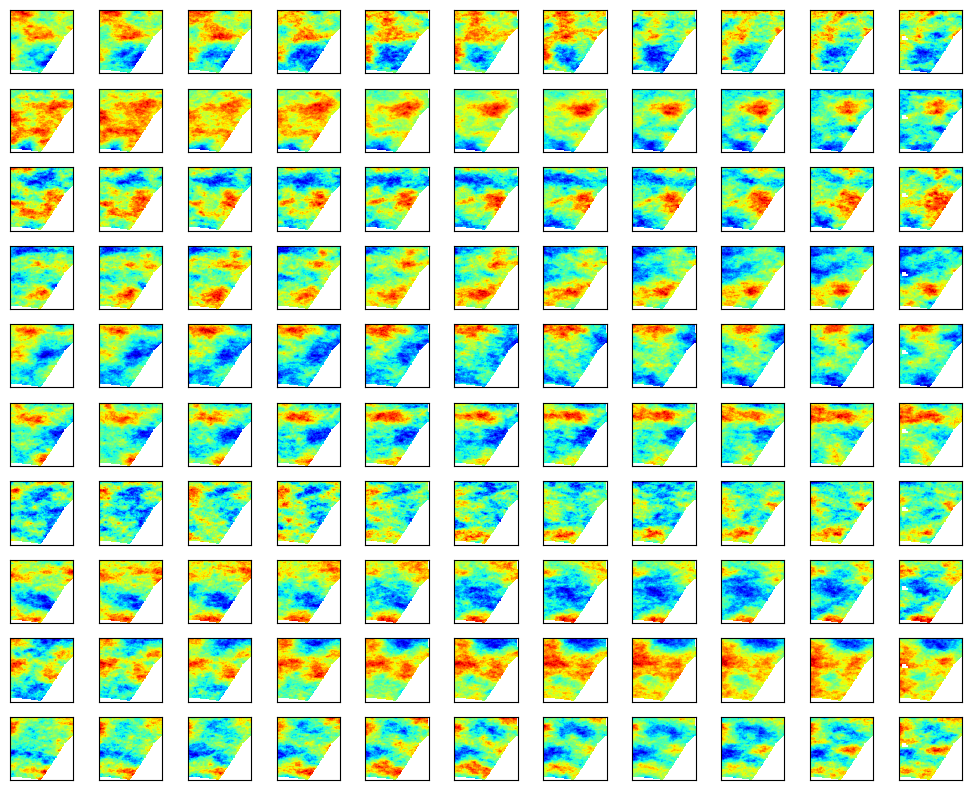

In [65]:
plt.figure(figsize=(10,8))
k = 0
for i in range(10):
    for j in range(11):
        plt.subplot(10,11,k+1)
        plt.imshow(perm_masked[i,:,:,j], cmap='jet')
        plt.xticks([]); plt.yticks([])
        k += 1
plt.tight_layout()
plt.show()

In [34]:
full = np.load('/mnt/e/MLTrainingImages/ProFluvsim/NTG_0.6/AmHighWT_20Med_Sinuosity.npy').reshape(256,256,128)
full.shape

(256, 256, 128)

In [47]:
k = np.linspace(48, 96, 11, dtype=int)

In [48]:
f = resize(full, (100,100,128), anti_aliasing=True)[...,k]
f.shape

(100, 100, 11)

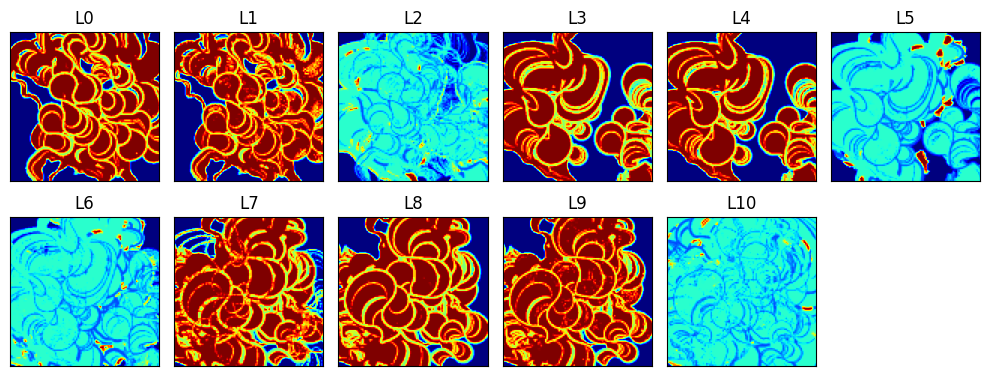

In [51]:
plt.figure(figsize=(10,4))
for i in range(11):
    plt.subplot(2,6,i+1)
    plt.imshow(f[:,:,i], cmap='jet')
    plt.title('L{}'.format(i))
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [60]:
318*4

1272

In [59]:
k0 = np.linspace(32, 48, 11, dtype=int)
k1 = np.linspace(48, 64, 11, dtype=int)
k2 = np.linspace(64, 80, 11, dtype=int)
k3 = np.linspace(80, 96, 11, dtype=int)

In [2]:
import os
from skimage.transform import rescale, resize_local_mean, resize
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [3]:
file_list = []
for root, dirs, files in os.walk('/mnt/e/MLTrainingImages'):
    for file in files:
        if file.endswith('.npy'):
            file_list.append(os.path.join(root, file))

In [56]:
facies = np.zeros((1272,100,100,11))

k0 = np.arange(32, 48)
k1 = np.arange(48, 64)
k2 = np.arange(64, 80)
k3 = np.arange(80, 96)
ks = [k0,k1,k2,k3]

p = 0
for i in range(318):
    for j in range(len(ks)):
        d  = np.load(file_list[i]).reshape(256,256,128)[...,ks[j]]
        facies[p] = pd.cut(resize(d, (100,100,11), anti_aliasing=True).flatten(), bins=len(np.unique(d)), labels=False).reshape(facies.shape[1:])
        p += 1

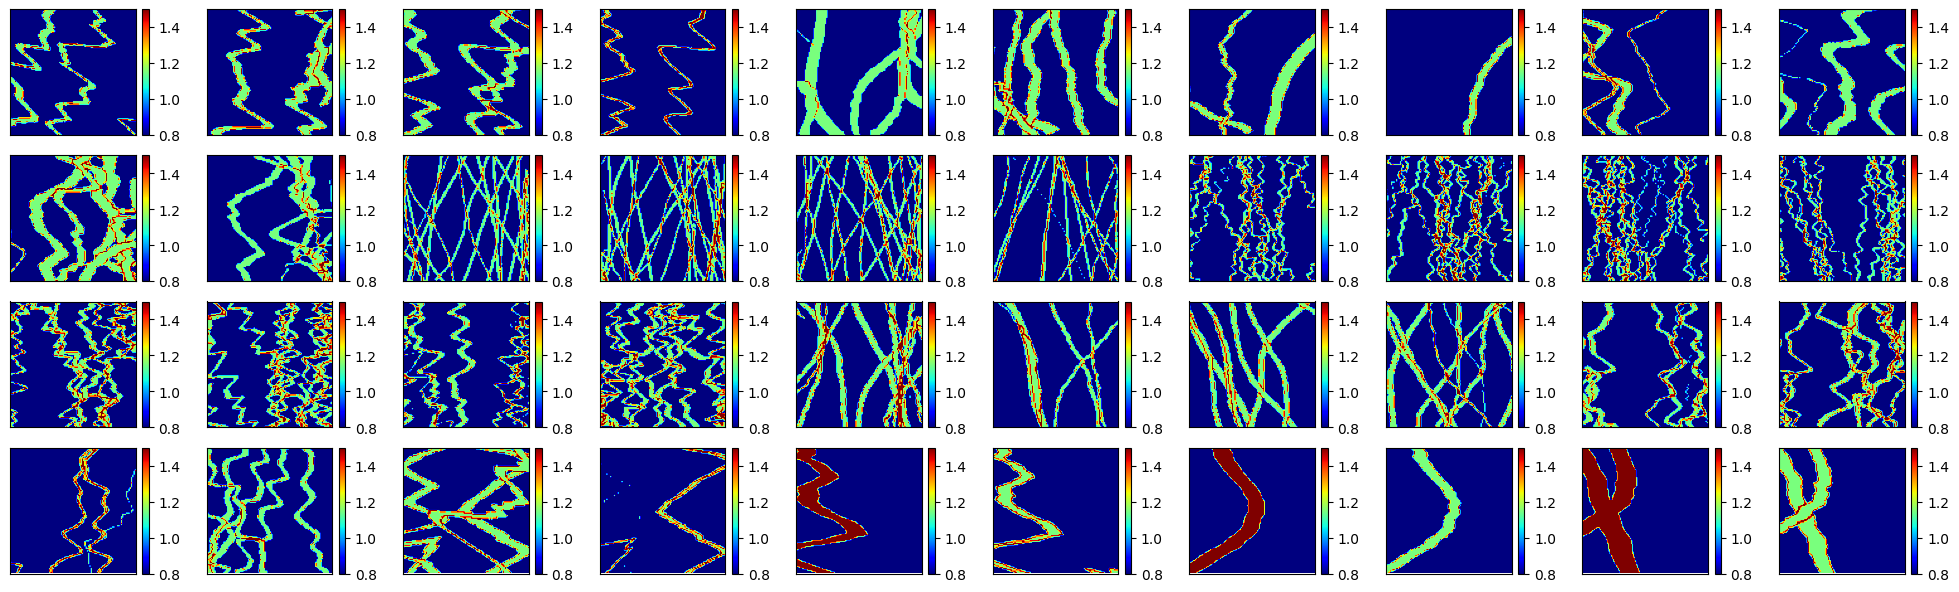

In [148]:
plt.figure(figsize=(20,6))
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(facies[i,:,:,0], cmap='jet')
    plt.colorbar(pad=0.04, fraction=0.046)
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [283]:
for i in range(1272):
    np.save('/mnt/e/PLACEMENT-CONTROL-OPTIM-CO2/data_100_100_11/facies/facies_{}'.format(i), facies[i])

In [291]:
k = np.array(pd.read_csv('/mnt/e/PLACEMENT-CONTROL-OPTIM-CO2/perm_all.csv')).reshape(100,100,11,100, order='F')
k = np.moveaxis(k, -1, 0)

p = 10**((k-7)/10)

print(p.shape, k.shape)

(100, 100, 100, 11) (100, 100, 100, 11)


In [294]:
f = np.zeros((100, 100, 100, 11))
for i in range(100):
    f[i] = np.load('/mnt/e/PLACEMENT-CONTROL-OPTIM-CO2/data_100_100_11/facies/facies_{}.npy'.format(i))
print(f.shape)

(100, 100, 100, 11)


In [304]:
fn = MinMaxScaler((0.95,1.15)).fit_transform(f.reshape(100,-1)).reshape(f.shape)

kn = MinMaxScaler((np.log10(0.2), np.log10(2000))).fit_transform(k.reshape(100,-1) * 10**fn.reshape(100,-1)).reshape(k.shape)
pn = MinMaxScaler((0.025, 0.3)).fit_transform(p.reshape(100,-1) * fn.reshape(100,-1)).reshape(p.shape)

In [313]:
kn.shape

(100, 100, 100, 11)

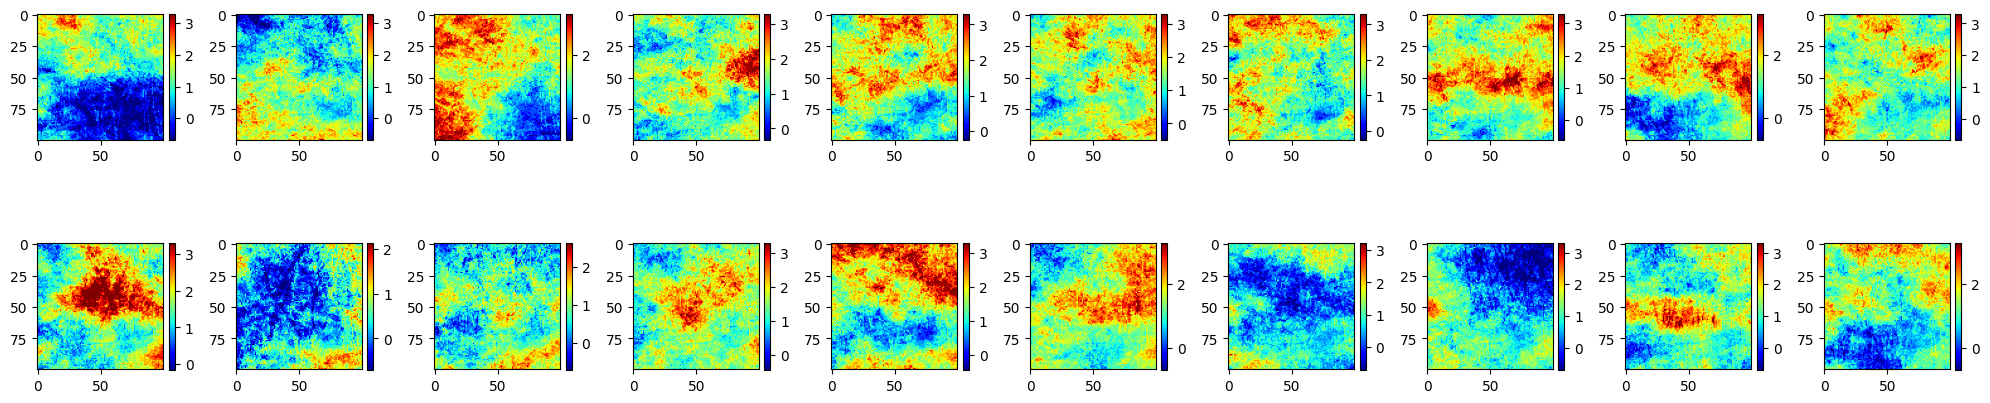

In [307]:
plt.figure(figsize=(20,5))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(kn[-i,...,0], cmap='jet')
    plt.colorbar(pad=0.04, fraction=0.046)

plt.tight_layout()
plt.show()

In [311]:
for i in range(100):
    np.save('/mnt/e/PLACEMENT-CONTROL-OPTIM-CO2/data_100_100_11/perm/perm_{}'.format(i), kn[i])
    np.save('/mnt/e/PLACEMENT-CONTROL-OPTIM-CO2/data_100_100_11/poro/poro_{}'.format(i), pn[i])

In [312]:
from scipy.io import savemat, loadmat

In [314]:
for i in range(100):
    savemat('/mnt/e/PLACEMENT-CONTROL-OPTIM-CO2/data_100_100_11/rock/rock_{}.mat'.format(i), {'perm': kn[i], 'poro': pn[i]})